## Figure 1 Literature Survey on SMILES Representations in Chemical Language Models

* 1-a Screening process

* 1-b Pie chart

([<matplotlib.patches.Wedge at 0x7b1d8bb81ab0>,
 [Text(0.9078416961821878, 0.6211468865518431, 'Canonicalized(RDkit)'),
  Text(0.9287607737885551, -0.589409386650471, 'Canonicalized(Openbabel)'),
  Text(0.5450046220517172, -0.9554946163858093, 'Canonicalized(Other)'),
  Text(-0.034551724841624325, -1.0994572198637238, 'Not Canonicalized'),
  Text(-1.1182210196888192, 0.16273214533735342, 'No Discription')],
 [Text(0.6189829746696734, 0.4235092408308021, '30.9%'),
  Text(0.6332459821285603, -0.4018700363525939, '6.2%'),
  Text(0.37159406048980714, -0.6514736020812336, '9.3%'),
  Text(-0.0235579942101984, -0.7496299226343571, '8.2%'),
  Text(-0.7718693764223707, 0.11232838350719972, '45.4%')])

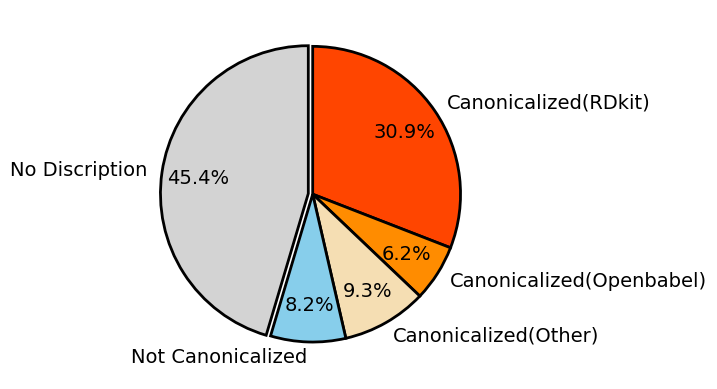

In [2]:
# Fig1-b
import numpy as np
import matplotlib.pyplot as plt 

x = np.array([30.9, 6.2, 9.3, 8.2, 45.4])
label = ["Canonicalized(RDkit)", "Canonicalized(Openbabel)", "Canonicalized(Other)", "Not Canonicalized", "No Discription"]
color = ["orangered","darkorange","wheat","skyblue","lightgray"]
plt.rcParams["font.size"] = 14
plt.pie(x, labels=label, counterclock=False, startangle=90, explode=[0, 0, 0, 0, 0.03], colors = color, wedgeprops={'linewidth': 2, 'edgecolor':"black"}, autopct="%1.1f%%",pctdistance=0.75)

## Figure 2 Variations in SMILES Representations Across Datasetss

* 2-a Distribution of syntactic variations in SMILES representations across datasets

* 2-b Example of SMILES syntactic variation

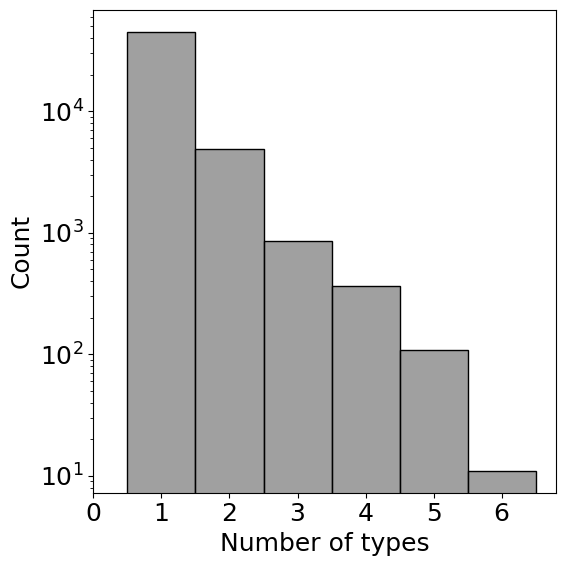

In [6]:
# Fig 2-a
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
canonical = []
removed = []
dataset = []

Molecule = ["BBBP", "clintox", "HIV", "sider", "tox21", "toxcast_data"]

for mol in Molecule:
    df_can = pd.read_csv(f"/workspace/MoleculeNet/MoleculeNet_raw/{mol}.csv", header=None, names=["canonical"])
    df_rem = pd.read_csv(f"/workspace/MoleculeNet/MoleculeNet_3Dremoved/{mol}.csv", header=None, names=["removed"])
    
    canonical.extend(df_can["canonical"].tolist())
    removed.extend(df_rem["removed"].tolist())
    dataset.extend([mol] * len(df_can))

df_all = pd.DataFrame({
    "canonical": canonical,
    "removed": removed,
    "dataset": dataset
})

df_all.dropna(inplace=True)

# グループごとに「canonicalもdatasetも両方異なる組み合わせ」を抽出
grouped = df_all.groupby("removed")

unique_both_diff_counts = []

for removed_val, group in grouped:

    unique_pairs = set(zip(group["canonical"], group["dataset"]))
    selected_pairs = []
    unique_pairs = list(unique_pairs)

    used = set()

    # 可能なペアを選択
    for i in range(len(unique_pairs)):
        pair1 = unique_pairs[i]
        
        if pair1 not in used:
            selected_pairs.append(pair1)
            used.add(pair1)

            for j in range(i+1, len(unique_pairs)):
                pair2 = unique_pairs[j]
                if pair2[0] == pair1[0]:
                    used.add(pair2)

    # グラフ構築（canonical と dataset の二部グラフ）
    G = nx.Graph()
    canonicals = set()
    datasets = set()

    for canonical, dataset in selected_pairs:
        G.add_node(canonical, bipartite=0)
        G.add_node(dataset, bipartite=1)
        G.add_edge(canonical, dataset)

        canonicals.add(canonical)
        datasets.add(dataset)

    # 最大マッチングを求める
    matching = nx.bipartite.maximum_matching(G, top_nodes=canonicals)

    pairs = [(u, v) for u, v in matching.items() if u in canonicals]

    unique_both_diff_counts.append(len(pairs))

df_plot = pd.DataFrame({"Count": unique_both_diff_counts})
plt.rcParams["font.size"] = 18
plt.figure(figsize=(6, 6))
sns.histplot(df_plot, x="Count", bins=range(0, max(unique_both_diff_counts)), discrete=True, color='gray',log=True)
plt.xlabel("Number of types")
plt.xticks(range(7))
plt.tight_layout()
plt.show()

## Figure 3 Impact of SMILES Variations on Latent Representations

* 3-a Character-level differences between raw and standardized SMILES

* 3-b (SI 2) t-SNE visualization of latent representations 

* 3-c Scatter plot showing the correlation between normalized Levenshtein distance and the difference in latent representations

=== 統計情報 for raw vs standard in bace ===
最大値: 0.9545454545454546
最小値: 0.20610687022900764
平均値: 0.65
標準偏差: 0.12

=== 統計情報 for raw vs standard in BBBP ===
最大値: 1.0
最小値: 0.0
平均値: 0.52
標準偏差: 0.25

=== 統計情報 for raw vs standard in clintox ===
最大値: 1.0
最小値: 0.0
平均値: 0.46
標準偏差: 0.22

=== 統計情報 for raw vs standard in sider ===
最大値: 0.96
最小値: 0.0
平均値: 0.54
標準偏差: 0.20

=== 統計情報 for raw vs standard in tox21 ===
最大値: 0.7361111111111112
最小値: 0.0
平均値: 0.01
標準偏差: 0.05

=== 統計情報 for raw vs standard in toxcast_data ===
最大値: 1.0
最小値: 0.0
平均値: 0.41
標準偏差: 0.26



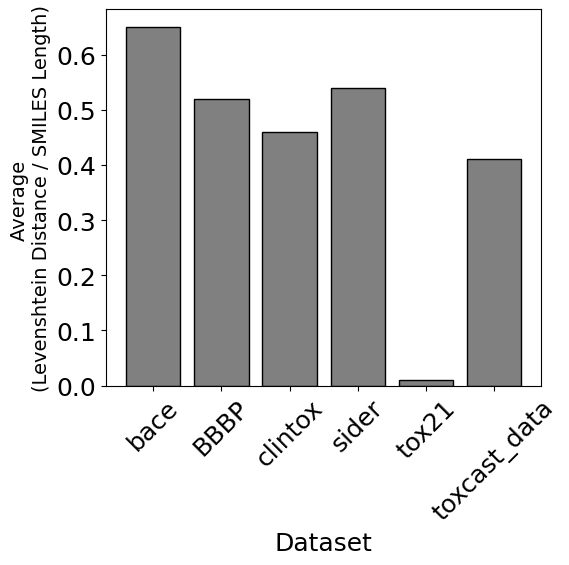

In [23]:
import pandas as pd
import Levenshtein
import numpy as np
import matplotlib.pyplot as plt

files = ["bace","BBBP","clintox","sider","tox21","toxcast_data"]

summary = []
for file1 in files:
    df1 = pd.read_csv("/workspace/MoleculeNet/MoleculeNet_raw/"+file1+".csv",header=None,names=["smiles"])
    df2 = pd.read_csv("/workspace/MoleculeNet/MoleculeNet_standardized/"+file1+".csv",header=None,names=["smiles"])

    df_concat = pd.concat([df1, df2], axis=1)

    df_concat.columns = ["smiles_old", "smiles_new"]

    distances = [
        Levenshtein.distance(str(a), str(b))
        for a, b in zip(df1["smiles"], df2["smiles"])
    ]

    df_concat["levenshtein_distance"] = distances

    normalized_distances = [
        d / max(len(str(a)), len(str(b))) if max(len(str(a)), len(str(b))) > 0 else 0
        for d, a, b in zip(distances, df1["smiles"], df2["smiles"])
    ]

    df_concat["normalized_levenshtein"] = normalized_distances

    max_dist = np.max(normalized_distances)
    min_dist = np.min(normalized_distances)
    mean_dist = np.mean(normalized_distances)
    std_dist = np.std(normalized_distances)

    print(f"=== 統計情報 for raw vs standard in {file1} ===")
    print(f"最大値: {max_dist}")
    print(f"最小値: {min_dist}")
    print(f"平均値: {mean_dist:.2f}")
    print(f"標準偏差: {std_dist:.2f}")
    print()

    summary.append({
        "input_file": file1,
        "max_distance": max_dist,
        "min_distance": min_dist,
        "mean_distance": round(mean_dist, 2),
        "std_distance": round(std_dist, 2)
    })
    max_index = np.argmax(distances)
    drug_max = df1["smiles"].iloc[max_index]
    smiles_max = df2["smiles"].iloc[max_index]

summary_df = pd.DataFrame(summary)
#summary_df.to_csv("levenshtein_summary_Mol.csv", index=False)


df_selected = summary_df[summary_df["input_file"].isin(files)]
df_selected["input_file"] = pd.Categorical(df_selected["input_file"], categories=files, ordered=True)
df_selected = df_selected.sort_values("input_file")


plt.figure(figsize=(6, 6))
plt.bar(
    df_selected["input_file"],
    df_selected["mean_distance"],
    capsize=5,  # エラーバーの線の端
    color="gray",
    edgecolor="black"
)
plt.rcParams["font.size"] = 18
plt.xlabel("Dataset")
plt.ylabel("Average \n(Levenshtein Distance / SMILES Length)",fontsize=14)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Using perplexity=30 for file: bace


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


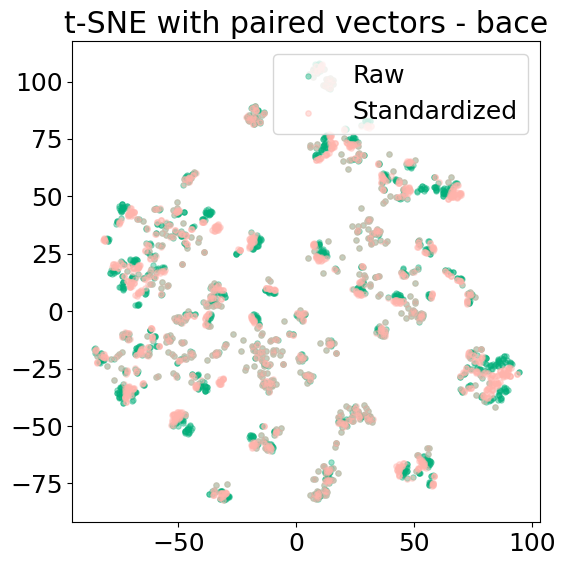

Using perplexity=40 for file: BBBP


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


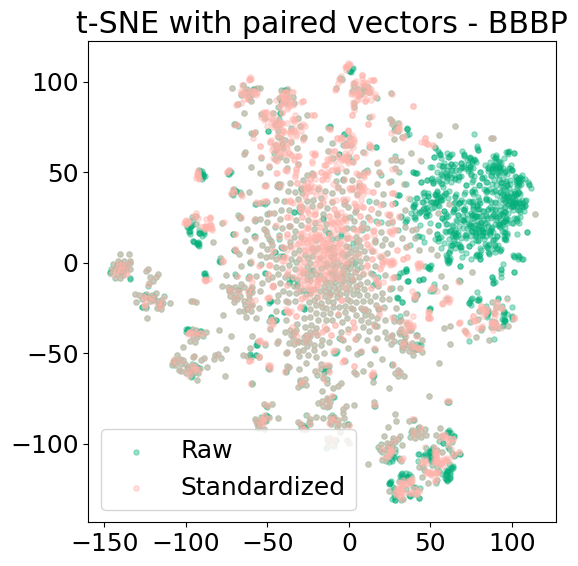

Using perplexity=29 for file: clintox


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


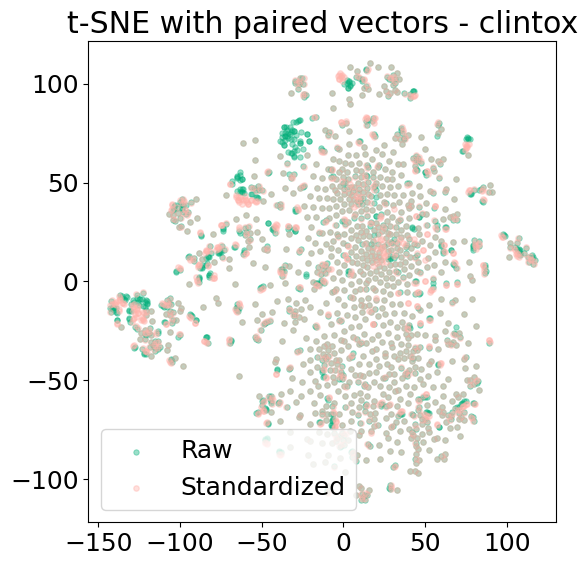

Using perplexity=27 for file: sider


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


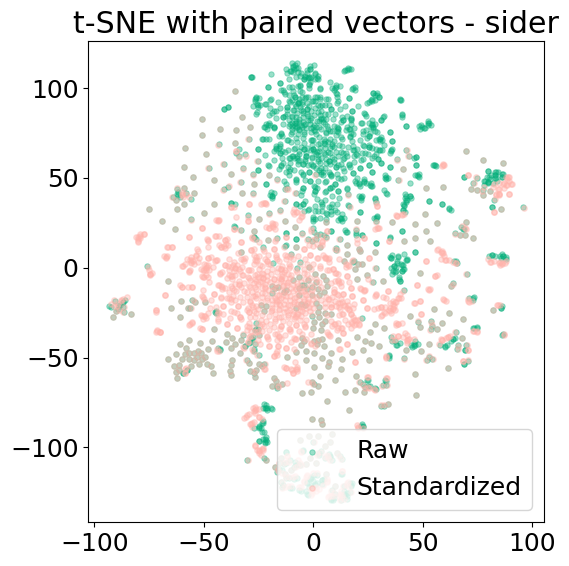

Using perplexity=50 for file: tox21


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


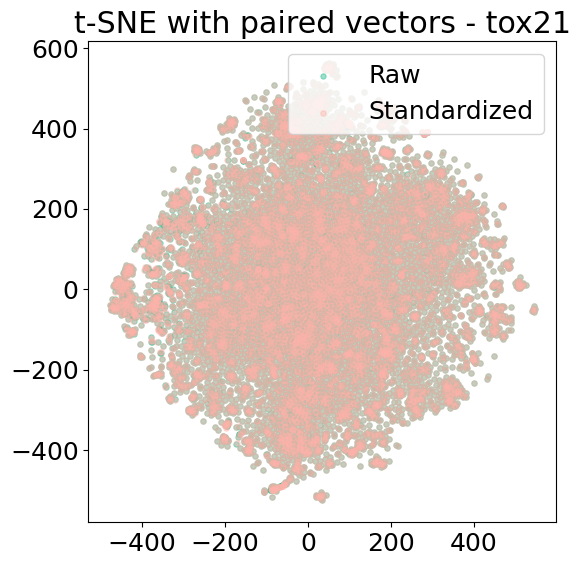

Using perplexity=50 for file: toxcast_data


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


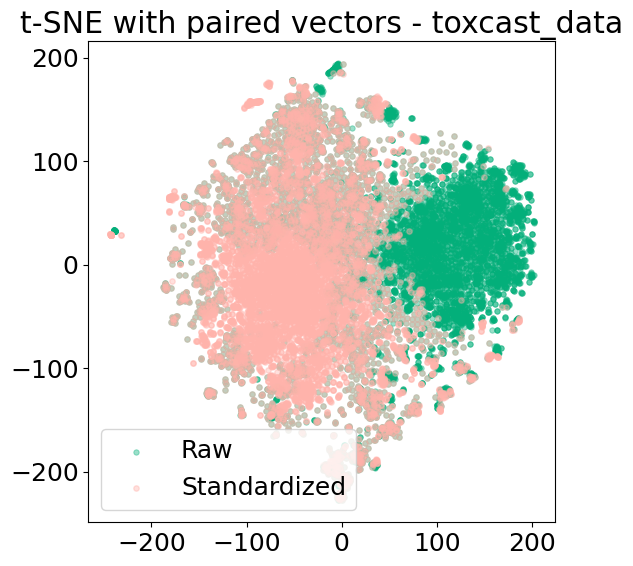

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.spatial.distance import euclidean
# Figure 3-b
for fil in files:
    paired_data = []
    labels = []
    # Load latent representations
    file1 = f"/workspace/Transformers_VAE_ex/result_ADME/250509_AllPubchem_Mol_n_1_n_{fil}/accumulates/mu/0.npy"
    file2 = f"/workspace/Transformers_VAE_ex/result_ADME/250509_AllPubchem_Mol_n_1_no_{fil}/accumulates/mu/0.npy"

    data1 = np.load(file1)
    data2 = np.load(file2)

    min_len = min(len(data1), len(data2))
    data1 = data1[:min_len]
    data2 = data2[:min_len]

    for i in range(min_len):
        paired_data.append(data2[i])
        paired_data.append(data1[i])
        labels.append("Raw")
        labels.append("Standardized")

    paired_data_np = np.vstack(paired_data)
    data_size = len(paired_data_np)

    perplexity = int(np.clip(data_size * 0.01, 5, 50))
    print(f"Using perplexity={perplexity} for file: {fil}")

    reducer = TSNE(random_state=42, perplexity=30, n_iter=5000)
    embedding = reducer.fit_transform(paired_data_np)
    color_map = {
        "Raw": "#03AF7A",          # Green
        "Standardized": "#FFB3AB"  # サーモンピンク
    }

    plt.figure(figsize=(6, 6))
    plt.rcParams["font.size"] = 18
    for label in ["Raw", "Standardized"]:
        idx = [i for i, l in enumerate(labels) if l == label]
        
        # スタイル分け：Raw → 縁あり、Standardized → 塗りつぶし
        if label == "Raw":
            plt.scatter(embedding[idx, 0], embedding[idx, 1],
                        facecolors=color_map[label],
                        edgecolors=color_map[label],
                        label=label,
                        alpha=0.4, s=15, linewidth=0.7)
        else:
            plt.scatter(embedding[idx, 0], embedding[idx, 1],
                        color=color_map[label],
                        label=label,
                        alpha=0.4, s=15)

    plt.title(f"t-SNE with paired vectors - {fil}")
    plt.legend()
    plt.tight_layout()
    plt.show()



In [25]:
#3-C
files = ["bace","BBBP","clintox","sider","tox21","toxcast_data"]

custom_colors = [
    "#FF4B00",  # red
    "#005AFF",  # blue
    "#03AF7A",  # green
    "#FFF100",   # yellow
    "#4DC4FF",  # cyan
    "#F6AA00"  # orange
    
]

plt.rcParams["font.size"] = 18
plt.figure(figsize=(6, 6))

# 凡例用のハンドルを保存
legend_handles = []

for idx, fil in enumerate(files):
    
    plt.scatter(dataset_distances[fil], dataset_csv_values[fil],
                alpha=0.3, s=10, color=custom_colors[idx], edgecolors='none')

    # plot for legend
    handle = plt.scatter([], [], color=custom_colors[idx], label=fil, s=30, alpha=1)
    legend_handles.append(handle)

plt.title("Latent Space Distance vs Levenshtein Distance by Dataset", fontsize=18)
plt.xlabel("Latent Space Distance", fontsize=16)
plt.ylabel("Levenshtein Distance / SMILES Length", fontsize=16)

plt.grid(True, linestyle='--', linewidth=0.5)

plt.legend(handles=legend_handles, markerscale=1.5, frameon=False, fontsize=9)

plt.tight_layout()
plt.show()


NameError: name 'dataset_distances' is not defined

<Figure size 600x600 with 0 Axes>

## Figure 4 Impact of SMILES Representational Variations on MTM Task Performance 

* 4-a,b Bar plots showing performance differences 

* 4-c Distribution of latent representation-level distances  

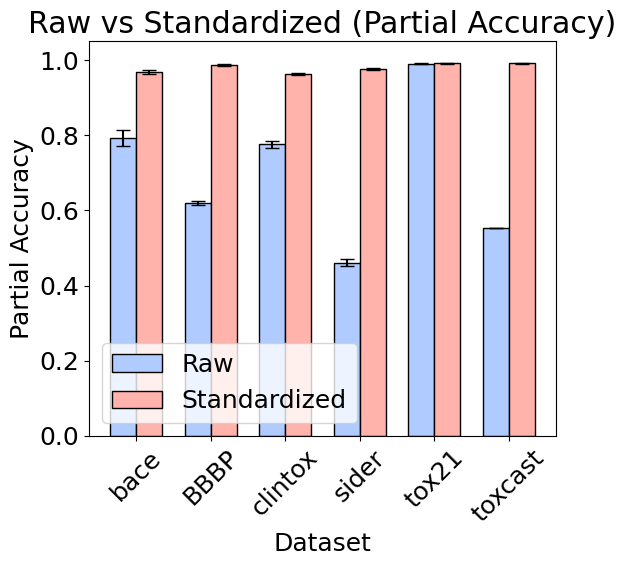

In [43]:
#4-a
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

dfs = pd.read_csv("/workspace/2406_paper/summary_with_params.csv")

df_raw = dfs[(dfs["Param_3"] == "n") & (dfs["Param_5"] == "no")]
df_std = dfs[(dfs["Param_3"] == "n") & (dfs["Param_5"] == "n")]

Mol = ["bace", "BBBP", "clintox", "sider", "tox21", "toxcast"]

raw_means = []
std_means = []
raw_stds = []
std_stds = []

for mol in Mol:
    raw_scores = df_raw[df_raw["Param_6"] == mol]["Partial accuracy"]
    std_scores = df_std[df_std["Param_6"] == mol]["Partial accuracy"]

    raw_means.append(np.mean(raw_scores))
    std_means.append(np.mean(std_scores))
    raw_stds.append(np.std(raw_scores))
    std_stds.append(np.std(std_scores))

# プロット
x = np.arange(len(Mol))  # データセットの数
width = 0.35  # 棒の幅

fig, ax = plt.subplots(figsize=(6, 6))
plt.rcParams["font.size"] = 18
# Barplot with error bars
bars1 = ax.bar(x - width/2, raw_means, width, yerr=raw_stds, label='Raw', color='#AFCBFF', edgecolor='black', capsize=5)
bars2 = ax.bar(x + width/2, std_means, width, yerr=std_stds, label='Standardized', color='#FFB3AB', edgecolor='black', capsize=5)

# 軸・ラベル設定
ax.set_ylabel('Partial Accuracy')
ax.set_xlabel('Dataset')
ax.set_title('Raw vs Standardized (Partial Accuracy)')
ax.set_xticks(x)
ax.set_xticklabels(Mol,rotation=45)
ax.legend()
ax.set_ylim(0, 1.05)

plt.tight_layout()
plt.show()


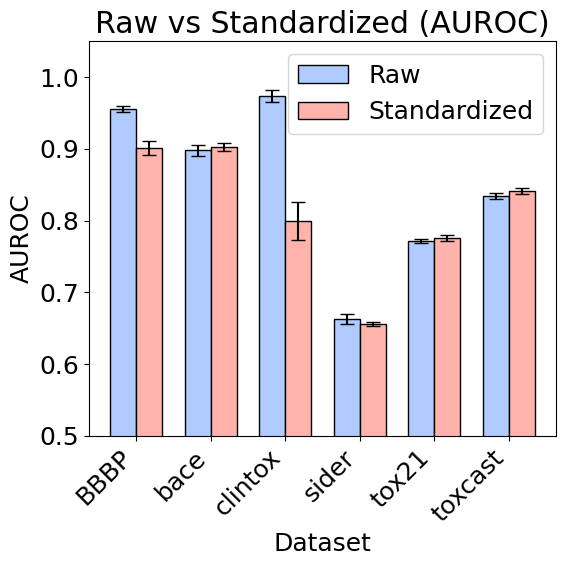

In [44]:
# 4-b
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# CSVの読み込み
df = pd.read_csv("/workspace/2406_paper/downstream.csv")  # ファイル名は適宜変更

# データをlong形式に変換
data_long = []
for i in range(1, 4):
    for index, row in df.iterrows():
        data_long.append({
            'Dataset': row['data'],
            'Type': 'Raw',
            'Value': row[f'no{i}']
        })
        data_long.append({
            'Dataset': row['data'],
            'Type': 'Standardized',
            'Value': row[f'n{i}']
        })

df_long = pd.DataFrame(data_long)

summary = df_long.groupby(['Dataset', 'Type'])['Value'].agg(['mean', 'std']).reset_index()

datasets = summary['Dataset'].unique()
x = np.arange(len(datasets))
width = 0.35

fig, ax = plt.subplots(figsize=(6,6))
plt.rcParams["font.size"] = 18
raw_means = summary[summary['Type'] == 'Raw']['mean'].values
std_means = summary[summary['Type'] == 'Standardized']['mean'].values
raw_stds = summary[summary['Type'] == 'Raw']['std'].values
std_stds = summary[summary['Type'] == 'Standardized']['std'].values

ax.bar(x - width/2, raw_means, width, yerr=raw_stds,
       label='Raw', color='#AFCBFF', edgecolor='black', capsize=5)
ax.bar(x + width/2, std_means, width, yerr=std_stds,
       label='Standardized', color='#FFB3AB', edgecolor='black', capsize=5)

ax.set_xticks(x)
ax.set_xticklabels(datasets, rotation=45, ha='right')
ax.set_ylabel('AUROC')
ax.set_xlabel('Dataset')
ax.set_title('Raw vs Standardized (AUROC)')
ax.set_ylim(0.5, 1.05)
ax.legend()

plt.tight_layout()
plt.show()


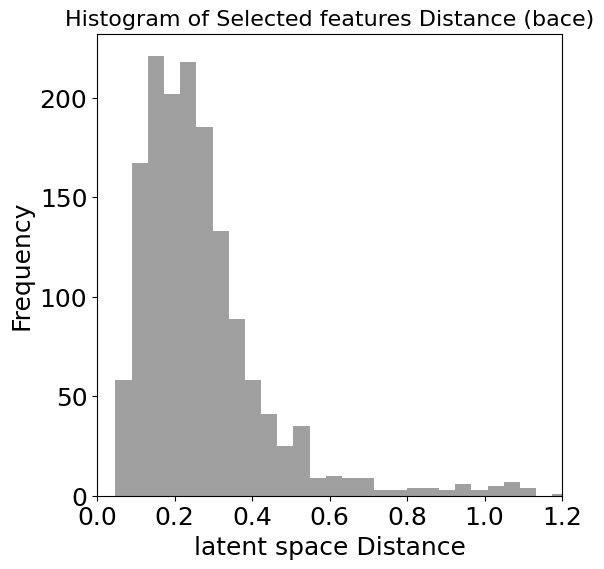

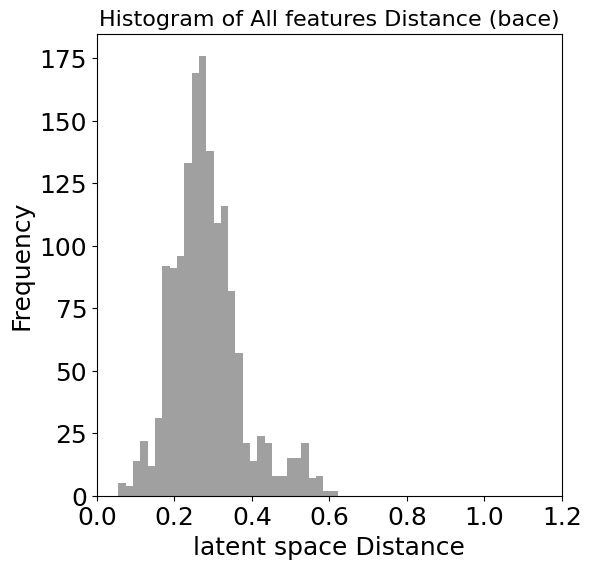

In [34]:
# 4-c(bace)
import numpy as np
import umap.umap_ as umap
import matplotlib.pyplot as plt
import numpy.linalg as LA

file1 = "/workspace/Transformers_VAE_ex/result_ADME/250509_AllPubchem_Mol_n_1_n_bace/accumulates/mu/0.npy"
file2 = "/workspace/Transformers_VAE_ex/result_ADME/250509_AllPubchem_Mol_n_1_no_bace/accumulates/mu/0.npy"

data1 = np.load(file1)
data2 = np.load(file2)

cols = [494,474,492,9,368]
#cols = [494,418,1,78,21,345]
data1_sub = data1[:, cols]
data2_sub = data2[:, cols]

plt.rcParams["font.size"] = 18

num_features_sub = data1_sub.shape[1]
distances = LA.norm(data1_sub - data2_sub, axis=1) / np.sqrt(num_features_sub)

plt.figure(figsize=(6,6))
plt.hist(distances, bins=30, alpha=0.75, color="gray")
plt.title("Histogram of Selected features Distance (bace)",fontsize=16)
plt.xlabel("latent space Distance")
plt.ylabel("Frequency")
plt.xlim(0,1.2)
plt.show()


num_features_all = data1.shape[1]
distances = LA.norm(data1 - data2, axis=1) / np.sqrt(num_features_all)

plt.figure(figsize=(6,6))
plt.hist(distances, bins=30, alpha=0.75, color="gray")
plt.title("Histogram of All features Distance (bace)",fontsize=16)
plt.xlabel("latent space Distance")
plt.ylabel("Frequency")
plt.xlim(0,1.2)
plt.show()

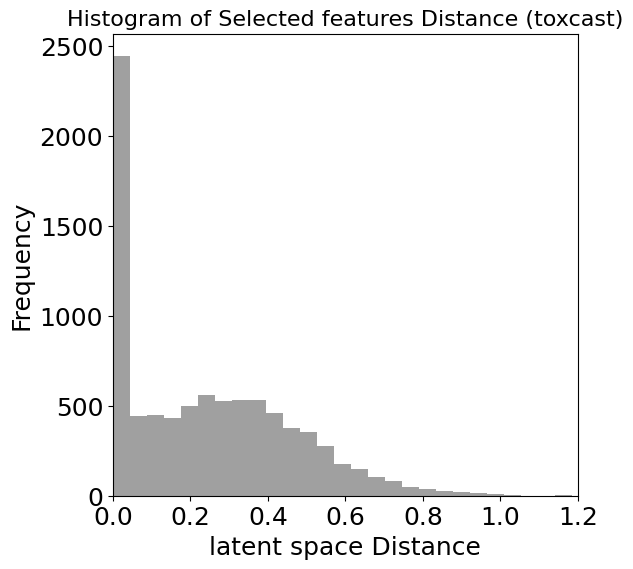

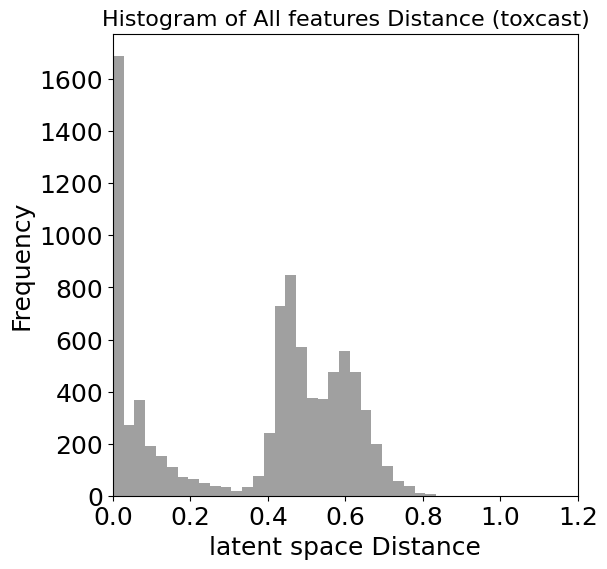

In [36]:
# 4-c(toxcast)
import numpy as np
import umap.umap_ as umap
import matplotlib.pyplot as plt
import numpy.linalg as LA

file1 = "/workspace/Transformers_VAE_ex/result_ADME/250509_AllPubchem_Mol_n_1_n_toxcast_data/accumulates/mu/0.npy"
file2 = "/workspace/Transformers_VAE_ex/result_ADME/250509_AllPubchem_Mol_n_1_no_toxcast_data/accumulates/mu/0.npy"

data1 = np.load(file1)
data2 = np.load(file2)

cols = [494,418,1,78,21,345]

data1_sub = data1[:, cols]
data2_sub = data2[:, cols]

plt.rcParams["font.size"] = 18

num_features_sub = data1_sub.shape[1]
distances = LA.norm(data1_sub - data2_sub, axis=1) / np.sqrt(num_features_sub)

plt.figure(figsize=(6,6))
plt.hist(distances, bins=30, alpha=0.75, color="gray")
plt.title("Histogram of Selected features Distance (toxcast)",fontsize=16)
plt.xlabel("latent space Distance")
plt.ylabel("Frequency")
plt.xlim(0,1.2)
plt.show()


num_features_all = data1.shape[1]
distances = LA.norm(data1 - data2, axis=1) / np.sqrt(num_features_all)

plt.figure(figsize=(6,6))
plt.hist(distances, bins=30, alpha=0.75, color="gray")
plt.title("Histogram of All features Distance (toxcast)",fontsize=16)
plt.xlabel("latent space Distance")
plt.ylabel("Frequency")
plt.xlim(0,1.2)
plt.show()

## Figure 5 Impacts of Stereochemical Annotations on Translation Tasks

* 5-a,b,c Bar plots showing the frequencies of the top 10 translation errors  

* 5-d resentative examples of reconstruction errors 

{'<padding>': 0, '<start>': 1, '<end>': 2, '[Si': 3, '[Sc': 4, '[Ni': 5, '[In': 6, '[Sn': 7, '@@': 8, 'He': 9, 'Li': 10, 'Be': 11, 'Ne': 12, 'Na': 13, 'Mg': 14, 'Al': 15, 'Cl': 16, 'Ar': 17, 'Ca': 18, 'Ti': 19, 'Cr': 20, 'Mn': 21, 'Fe': 22, 'Co': 23, 'Cu': 24, 'Zn': 25, 'Ga': 26, 'Ge': 27, 'As': 28, 'Se': 29, 'Br': 30, 'Kr': 31, 'Rb': 32, 'Sr': 33, 'Zr': 34, 'Nb': 35, 'Mo': 36, 'Tc': 37, 'Ru': 38, 'Rh': 39, 'Pd': 40, 'Ag': 41, 'Cd': 42, 'Sb': 43, 'Te': 44, 'Xe': 45, 'Cs': 46, 'Ba': 47, 'La': 48, 'Ce': 49, 'Pr': 50, 'Nd': 51, 'Pm': 52, 'Sm': 53, 'Eu': 54, 'Gd': 55, 'Tb': 56, 'Dy': 57, 'Ho': 58, 'Er': 59, 'Tm': 60, 'Yb': 61, 'Lu': 62, 'Hf': 63, 'Ta': 64, 'Re': 65, 'Os': 66, 'Ir': 67, 'Pt': 68, 'Au': 69, 'Hg': 70, 'Tl': 71, 'Pb': 72, 'Bi': 73, 'Po': 74, 'At': 75, 'Rn': 76, 'Fr': 77, 'Ra': 78, 'Ac': 79, 'Th': 80, 'Pa': 81, 'se': 82, 'te': 83, '0': 84, '1': 85, '2': 86, '3': 87, '4': 88, '5': 89, '6': 90, '7': 91, '8': 92, '9': 93, '(': 94, ')': 95, '[': 96, ']': 97, ':': 98, '=': 99, '@': 

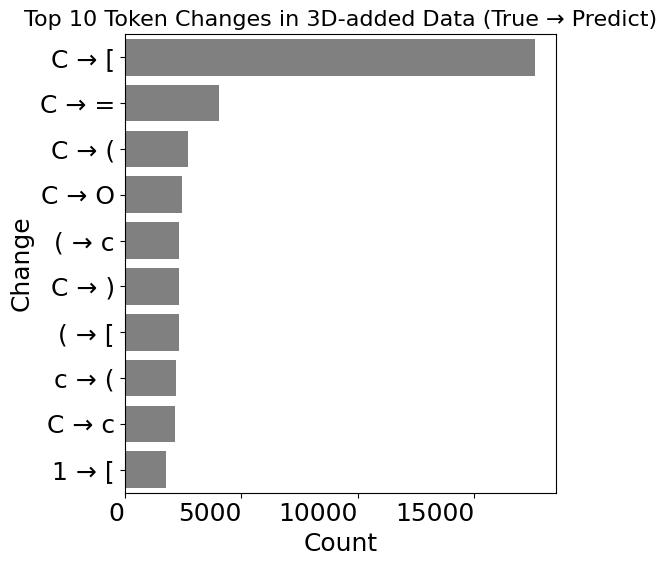

In [56]:
# 5-a
from collections import Counter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("/workspace/2403_SMARTS/tox_reset.csv")
df2 = pd.read_csv("/workspace/2403_SMARTS/tox_normal.csv")
df3 = pd.read_csv("/workspace/2403_SMARTS/tox_processed.csv")
df4 = pd.read_csv("/workspace/2403_SMARTS/tox_processed_normal.csv")
c=pd.read_csv("/workspace/2406_paper/large_vocs_true.csv")
mapping = {'<padding>': 0, '<start>': 1, '<end>': 2, '[Si': 3, '[Sc': 4, '[Ni': 5, '[In': 6, '[Sn': 7, '@@': 8, 'He': 9, 'Li': 10, 'Be': 11, 'Ne': 12, 'Na': 13, 'Mg': 14, 'Al': 15, 'Cl': 16, 'Ar': 17, 'Ca': 18, 'Ti': 19, 'Cr': 20, 'Mn': 21, 'Fe': 22, 'Co': 23, 'Cu': 24, 'Zn': 25, 'Ga': 26, 'Ge': 27, 'As': 28, 'Se': 29, 'Br': 30, 'Kr': 31, 'Rb': 32, 'Sr': 33, 'Zr': 34, 'Nb': 35, 'Mo': 36, 'Tc': 37, 'Ru': 38, 'Rh': 39, 'Pd': 40, 'Ag': 41, 'Cd': 42, 'Sb': 43, 'Te': 44, 'Xe': 45, 'Cs': 46, 'Ba': 47, 'La': 48, 'Ce': 49, 'Pr': 50, 'Nd': 51, 'Pm': 52, 'Sm': 53, 'Eu': 54, 'Gd': 55, 'Tb': 56, 'Dy': 57, 'Ho': 58, 'Er': 59, 'Tm': 60, 'Yb': 61, 'Lu': 62, 'Hf': 63, 'Ta': 64, 'Re': 65, 'Os': 66, 'Ir': 67, 'Pt': 68, 'Au': 69, 'Hg': 70, 'Tl': 71, 'Pb': 72, 'Bi': 73, 'Po': 74, 'At': 75, 'Rn': 76, 'Fr': 77, 'Ra': 78, 'Ac': 79, 'Th': 80, 'Pa': 81, 'se': 82, 'te': 83, '0': 84, '1': 85, '2': 86, '3': 87, '4': 88, '5': 89, '6': 90, '7': 91, '8': 92, '9': 93, '(': 94, ')': 95, '[': 96, ']': 97, ':': 98, '=': 99, '@': 100, '+': 101, '/': 102, '\\': 103, '.': 104, '-': 105, '#': 106, '%': 107, 'c': 108, 'i': 109, 'o': 110, 'n': 111, 'p': 112, 's': 113, 'b': 114, 'H': 115, 'B': 116, 'C': 117, 'N': 118, 'O': 119, 'F': 120, 'P': 121, 'S': 122, 'K': 123, 'V': 124, 'Y': 125, 'I': 126, 'W': 127, 'U': 128}
Token = VocabularyTokenizer(vocs=c["voc"])

all_elements = set()

for fi in [df,df2,df3,df4]:
    for i in range(len(fi)):
        all_elements.update(Token.tokenize(fi.loc[i, 'predict']))
        all_elements.update(Token.tokenize(fi.loc[i, 'true']))

filtered_mapping = {key: value for key, value in mapping.items() if value in all_elements}
filtered_values = [value for value in filtered_mapping.values() ]
 
total_diff_count = Counter()

reverse_mapping = {v: k for k, v in filtered_mapping.items()}

for i in range(len(df4)):
    base_value = df4.loc[i, 'predict']
    compare_value = df4.loc[i, 'true']
    
    k = Token.tokenize(base_value)
    l = Token.tokenize(compare_value)
    differences = []


    for a, b in zip(k, l):
        if a - b != 0:
            differences.append((reverse_mapping[a], reverse_mapping[b]))
            
    total_diff_count.update(differences)
    

top_diffs = total_diff_count.most_common(10)

before_tokens = [pair[0][0] for pair in top_diffs]
after_tokens = [pair[0][1] for pair in top_diffs]
counts = [pair[1] for pair in top_diffs]

df_plot = pd.DataFrame({
    'Change': [f'{a} → {b}' for b, a in zip(before_tokens, after_tokens)],
    'Before': before_tokens,
    'After': after_tokens,
    'Count': counts
})
plt.rcParams["font.size"] = 18

plt.figure(figsize=(6, 6))
ax = sns.barplot(y='Change', x='Count', data=df_plot, color="gray")

plt.title('Top 10 Token Changes in 3D-added Data (True → Predict)',fontsize=16)
plt.xticks(ha='right')
plt.tight_layout()
plt.show()

{'<padding>': 0, '<start>': 1, '<end>': 2, '[Si': 3, '[Sc': 4, '[Ni': 5, '[In': 6, '[Sn': 7, '@@': 8, 'He': 9, 'Li': 10, 'Be': 11, 'Ne': 12, 'Na': 13, 'Mg': 14, 'Al': 15, 'Cl': 16, 'Ar': 17, 'Ca': 18, 'Ti': 19, 'Cr': 20, 'Mn': 21, 'Fe': 22, 'Co': 23, 'Cu': 24, 'Zn': 25, 'Ga': 26, 'Ge': 27, 'As': 28, 'Se': 29, 'Br': 30, 'Kr': 31, 'Rb': 32, 'Sr': 33, 'Zr': 34, 'Nb': 35, 'Mo': 36, 'Tc': 37, 'Ru': 38, 'Rh': 39, 'Pd': 40, 'Ag': 41, 'Cd': 42, 'Sb': 43, 'Te': 44, 'Xe': 45, 'Cs': 46, 'Ba': 47, 'La': 48, 'Ce': 49, 'Pr': 50, 'Nd': 51, 'Pm': 52, 'Sm': 53, 'Eu': 54, 'Gd': 55, 'Tb': 56, 'Dy': 57, 'Ho': 58, 'Er': 59, 'Tm': 60, 'Yb': 61, 'Lu': 62, 'Hf': 63, 'Ta': 64, 'Re': 65, 'Os': 66, 'Ir': 67, 'Pt': 68, 'Au': 69, 'Hg': 70, 'Tl': 71, 'Pb': 72, 'Bi': 73, 'Po': 74, 'At': 75, 'Rn': 76, 'Fr': 77, 'Ra': 78, 'Ac': 79, 'Th': 80, 'Pa': 81, 'se': 82, 'te': 83, '0': 84, '1': 85, '2': 86, '3': 87, '4': 88, '5': 89, '6': 90, '7': 91, '8': 92, '9': 93, '(': 94, ')': 95, '[': 96, ']': 97, ':': 98, '=': 99, '@': 

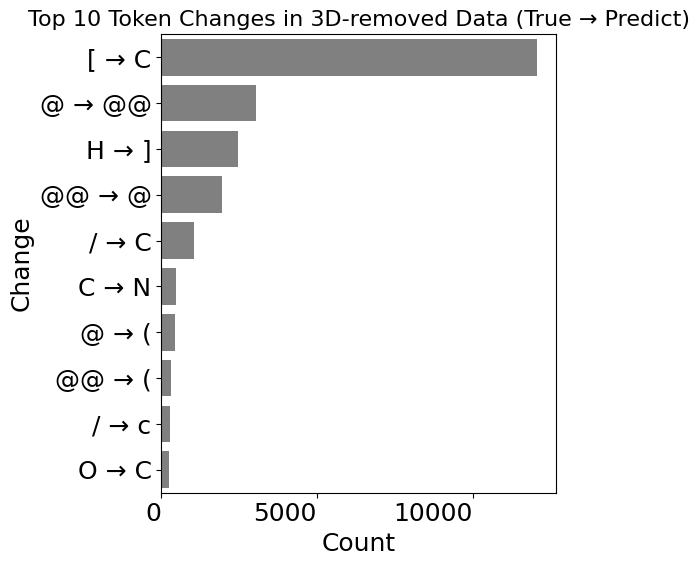

In [54]:
# 5-b
from collections import Counter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("/workspace/2403_SMARTS/tox_reset.csv")
df2 = pd.read_csv("/workspace/2403_SMARTS/tox_normal.csv")
df3 = pd.read_csv("/workspace/2403_SMARTS/tox_processed.csv")
df4 = pd.read_csv("/workspace/2403_SMARTS/tox_reset_normal.csv")
c=pd.read_csv("/workspace/2406_paper/large_vocs_true.csv")
mapping = {'<padding>': 0, '<start>': 1, '<end>': 2, '[Si': 3, '[Sc': 4, '[Ni': 5, '[In': 6, '[Sn': 7, '@@': 8, 'He': 9, 'Li': 10, 'Be': 11, 'Ne': 12, 'Na': 13, 'Mg': 14, 'Al': 15, 'Cl': 16, 'Ar': 17, 'Ca': 18, 'Ti': 19, 'Cr': 20, 'Mn': 21, 'Fe': 22, 'Co': 23, 'Cu': 24, 'Zn': 25, 'Ga': 26, 'Ge': 27, 'As': 28, 'Se': 29, 'Br': 30, 'Kr': 31, 'Rb': 32, 'Sr': 33, 'Zr': 34, 'Nb': 35, 'Mo': 36, 'Tc': 37, 'Ru': 38, 'Rh': 39, 'Pd': 40, 'Ag': 41, 'Cd': 42, 'Sb': 43, 'Te': 44, 'Xe': 45, 'Cs': 46, 'Ba': 47, 'La': 48, 'Ce': 49, 'Pr': 50, 'Nd': 51, 'Pm': 52, 'Sm': 53, 'Eu': 54, 'Gd': 55, 'Tb': 56, 'Dy': 57, 'Ho': 58, 'Er': 59, 'Tm': 60, 'Yb': 61, 'Lu': 62, 'Hf': 63, 'Ta': 64, 'Re': 65, 'Os': 66, 'Ir': 67, 'Pt': 68, 'Au': 69, 'Hg': 70, 'Tl': 71, 'Pb': 72, 'Bi': 73, 'Po': 74, 'At': 75, 'Rn': 76, 'Fr': 77, 'Ra': 78, 'Ac': 79, 'Th': 80, 'Pa': 81, 'se': 82, 'te': 83, '0': 84, '1': 85, '2': 86, '3': 87, '4': 88, '5': 89, '6': 90, '7': 91, '8': 92, '9': 93, '(': 94, ')': 95, '[': 96, ']': 97, ':': 98, '=': 99, '@': 100, '+': 101, '/': 102, '\\': 103, '.': 104, '-': 105, '#': 106, '%': 107, 'c': 108, 'i': 109, 'o': 110, 'n': 111, 'p': 112, 's': 113, 'b': 114, 'H': 115, 'B': 116, 'C': 117, 'N': 118, 'O': 119, 'F': 120, 'P': 121, 'S': 122, 'K': 123, 'V': 124, 'Y': 125, 'I': 126, 'W': 127, 'U': 128}
Token = VocabularyTokenizer(vocs=c["voc"])

all_elements = set()

for fi in [df,df2,df3,df4]:
    for i in range(len(fi)):
        all_elements.update(Token.tokenize(fi.loc[i, 'predict']))
        all_elements.update(Token.tokenize(fi.loc[i, 'true']))

filtered_mapping = {key: value for key, value in mapping.items() if value in all_elements}
filtered_values = [value for value in filtered_mapping.values() ]
 
total_diff_count = Counter()

reverse_mapping = {v: k for k, v in filtered_mapping.items()}

for i in range(len(df4)):
    base_value = df4.loc[i, 'predict']
    compare_value = df4.loc[i, 'true']
    
    k = Token.tokenize(base_value)
    l = Token.tokenize(compare_value)
    differences = []


    for a, b in zip(k, l):
        if a - b != 0:
            differences.append((reverse_mapping[a], reverse_mapping[b]))
            
    total_diff_count.update(differences)
    

top_diffs = total_diff_count.most_common(10)

before_tokens = [pair[0][0] for pair in top_diffs]
after_tokens = [pair[0][1] for pair in top_diffs]
counts = [pair[1] for pair in top_diffs]

df_plot = pd.DataFrame({
    'Change': [f'{a} → {b}' for b, a in zip(before_tokens, after_tokens)],
    'Before': before_tokens,
    'After': after_tokens,
    'Count': counts
})
plt.rcParams["font.size"] = 18

plt.figure(figsize=(6, 6))
ax = sns.barplot(y='Change', x='Count', data=df_plot, color="gray")

plt.title('Top 10 Token Changes in 3D-removed Data (True → Predict)',fontsize=16)
plt.xticks(ha='right')
plt.tight_layout()
plt.show()

{'<padding>': 0, '<start>': 1, '<end>': 2, '[Si': 3, '[Sc': 4, '[Ni': 5, '[In': 6, '[Sn': 7, '@@': 8, 'He': 9, 'Li': 10, 'Be': 11, 'Ne': 12, 'Na': 13, 'Mg': 14, 'Al': 15, 'Cl': 16, 'Ar': 17, 'Ca': 18, 'Ti': 19, 'Cr': 20, 'Mn': 21, 'Fe': 22, 'Co': 23, 'Cu': 24, 'Zn': 25, 'Ga': 26, 'Ge': 27, 'As': 28, 'Se': 29, 'Br': 30, 'Kr': 31, 'Rb': 32, 'Sr': 33, 'Zr': 34, 'Nb': 35, 'Mo': 36, 'Tc': 37, 'Ru': 38, 'Rh': 39, 'Pd': 40, 'Ag': 41, 'Cd': 42, 'Sb': 43, 'Te': 44, 'Xe': 45, 'Cs': 46, 'Ba': 47, 'La': 48, 'Ce': 49, 'Pr': 50, 'Nd': 51, 'Pm': 52, 'Sm': 53, 'Eu': 54, 'Gd': 55, 'Tb': 56, 'Dy': 57, 'Ho': 58, 'Er': 59, 'Tm': 60, 'Yb': 61, 'Lu': 62, 'Hf': 63, 'Ta': 64, 'Re': 65, 'Os': 66, 'Ir': 67, 'Pt': 68, 'Au': 69, 'Hg': 70, 'Tl': 71, 'Pb': 72, 'Bi': 73, 'Po': 74, 'At': 75, 'Rn': 76, 'Fr': 77, 'Ra': 78, 'Ac': 79, 'Th': 80, 'Pa': 81, 'se': 82, 'te': 83, '0': 84, '1': 85, '2': 86, '3': 87, '4': 88, '5': 89, '6': 90, '7': 91, '8': 92, '9': 93, '(': 94, ')': 95, '[': 96, ']': 97, ':': 98, '=': 99, '@': 

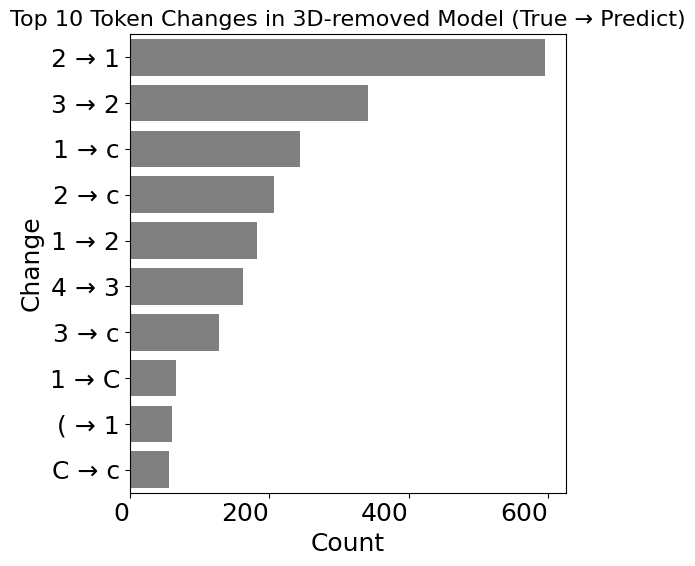

In [57]:
# 5-c
from collections import Counter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("/workspace/2403_SMARTS/tox_reset.csv")
df2 = pd.read_csv("/workspace/2403_SMARTS/tox_normal.csv")
df3 = pd.read_csv("/workspace/2403_SMARTS/tox_processed.csv")
df4 = pd.read_csv("/workspace/2403_SMARTS/tox_reset_normal.csv")
c=pd.read_csv("/workspace/2406_paper/large_vocs_true.csv")
mapping = {'<padding>': 0, '<start>': 1, '<end>': 2, '[Si': 3, '[Sc': 4, '[Ni': 5, '[In': 6, '[Sn': 7, '@@': 8, 'He': 9, 'Li': 10, 'Be': 11, 'Ne': 12, 'Na': 13, 'Mg': 14, 'Al': 15, 'Cl': 16, 'Ar': 17, 'Ca': 18, 'Ti': 19, 'Cr': 20, 'Mn': 21, 'Fe': 22, 'Co': 23, 'Cu': 24, 'Zn': 25, 'Ga': 26, 'Ge': 27, 'As': 28, 'Se': 29, 'Br': 30, 'Kr': 31, 'Rb': 32, 'Sr': 33, 'Zr': 34, 'Nb': 35, 'Mo': 36, 'Tc': 37, 'Ru': 38, 'Rh': 39, 'Pd': 40, 'Ag': 41, 'Cd': 42, 'Sb': 43, 'Te': 44, 'Xe': 45, 'Cs': 46, 'Ba': 47, 'La': 48, 'Ce': 49, 'Pr': 50, 'Nd': 51, 'Pm': 52, 'Sm': 53, 'Eu': 54, 'Gd': 55, 'Tb': 56, 'Dy': 57, 'Ho': 58, 'Er': 59, 'Tm': 60, 'Yb': 61, 'Lu': 62, 'Hf': 63, 'Ta': 64, 'Re': 65, 'Os': 66, 'Ir': 67, 'Pt': 68, 'Au': 69, 'Hg': 70, 'Tl': 71, 'Pb': 72, 'Bi': 73, 'Po': 74, 'At': 75, 'Rn': 76, 'Fr': 77, 'Ra': 78, 'Ac': 79, 'Th': 80, 'Pa': 81, 'se': 82, 'te': 83, '0': 84, '1': 85, '2': 86, '3': 87, '4': 88, '5': 89, '6': 90, '7': 91, '8': 92, '9': 93, '(': 94, ')': 95, '[': 96, ']': 97, ':': 98, '=': 99, '@': 100, '+': 101, '/': 102, '\\': 103, '.': 104, '-': 105, '#': 106, '%': 107, 'c': 108, 'i': 109, 'o': 110, 'n': 111, 'p': 112, 's': 113, 'b': 114, 'H': 115, 'B': 116, 'C': 117, 'N': 118, 'O': 119, 'F': 120, 'P': 121, 'S': 122, 'K': 123, 'V': 124, 'Y': 125, 'I': 126, 'W': 127, 'U': 128}
Token = VocabularyTokenizer(vocs=c["voc"])

all_elements = set()

for fi in [df,df2,df3,df4]:
    for i in range(len(fi)):
        all_elements.update(Token.tokenize(fi.loc[i, 'predict']))
        all_elements.update(Token.tokenize(fi.loc[i, 'true']))

filtered_mapping = {key: value for key, value in mapping.items() if value in all_elements}
filtered_values = [value for value in filtered_mapping.values() ]
 
total_diff_count = Counter()

reverse_mapping = {v: k for k, v in filtered_mapping.items()}

for i in range(len(df)):
    base_value = df.loc[i, 'predict']
    compare_value = df.loc[i, 'true']
    
    k = Token.tokenize(base_value)
    l = Token.tokenize(compare_value)
    differences = []


    for a, b in zip(k, l):
        if a - b != 0:
            differences.append((reverse_mapping[a], reverse_mapping[b]))
            
    total_diff_count.update(differences)
    

top_diffs = total_diff_count.most_common(10)

before_tokens = [pair[0][0] for pair in top_diffs]
after_tokens = [pair[0][1] for pair in top_diffs]
counts = [pair[1] for pair in top_diffs]

df_plot = pd.DataFrame({
    'Change': [f'{a} → {b}' for b, a in zip(before_tokens, after_tokens)],
    'Before': before_tokens,
    'After': after_tokens,
    'Count': counts
})
plt.rcParams["font.size"] = 18

plt.figure(figsize=(6, 6))
ax = sns.barplot(y='Change', x='Count', data=df_plot, color="gray")

plt.title('Top 10 Token Changes in 3D-removed Model (True → Predict)',fontsize=16)
plt.xticks(ha='right')
plt.tight_layout()
plt.show()

In [47]:
class VocabularyTokenizer():
    def __init__(self, vocs):
        """
        Parameters
        ----------
        vocs: array-like of str
        """
        vocs = sorted(list(vocs), key=lambda x:len(x), reverse=True)
        vocs_with_specials = ['<padding>', '<start>', '<end>'] + vocs
        self.voc_lens = np.sort(np.unique([len(voc) for voc in vocs]))[::-1]
        self.min_voc_len = self.voc_lens[-1]
        self.pad_token = 0
        self.start_token = 1
        self.end_token = 2
        self.voc2tok = {voc: tok for tok, voc in enumerate(vocs_with_specials)}
        print(self.voc2tok)
        self.tok2voc = np.array(vocs_with_specials)

    def tokenize(self, string):
        string_left = string
        toks = [self.start_token]
        while len(string_left) > 0:
            for voc_len in self.voc_lens:
                if string_left[:voc_len] in self.voc2tok:
                    toks.append(self.voc2tok[string_left[:voc_len]])
                    string_left = string_left[voc_len:]
                    break
                if voc_len == self.min_voc_len:
                    raise KeyError(f"Unknown keyward '{string_left}' in {string}")
        toks.append(self.end_token)
        return toks

    def detokenize(self, toks):
        """
        Parameters
        ----------
        toks: array_like of int

        Returns
        -------
        string: str
            detokenized string.
        """
        string = ""
        for tok in toks:
            if tok == self.end_token:
                break
            elif tok != self.start_token:
                string += self.tok2voc[tok]
        return string

    @property
    def voc_size(self):
        return len(self.tok2voc)

## Figure S1 Score Differences Between Models Trained on Latent Representations Derived from Raw and Standardized SMILES

* S1-a Bar plots of partial accuracy scores

* S1-b Bar plots of AUROC scores

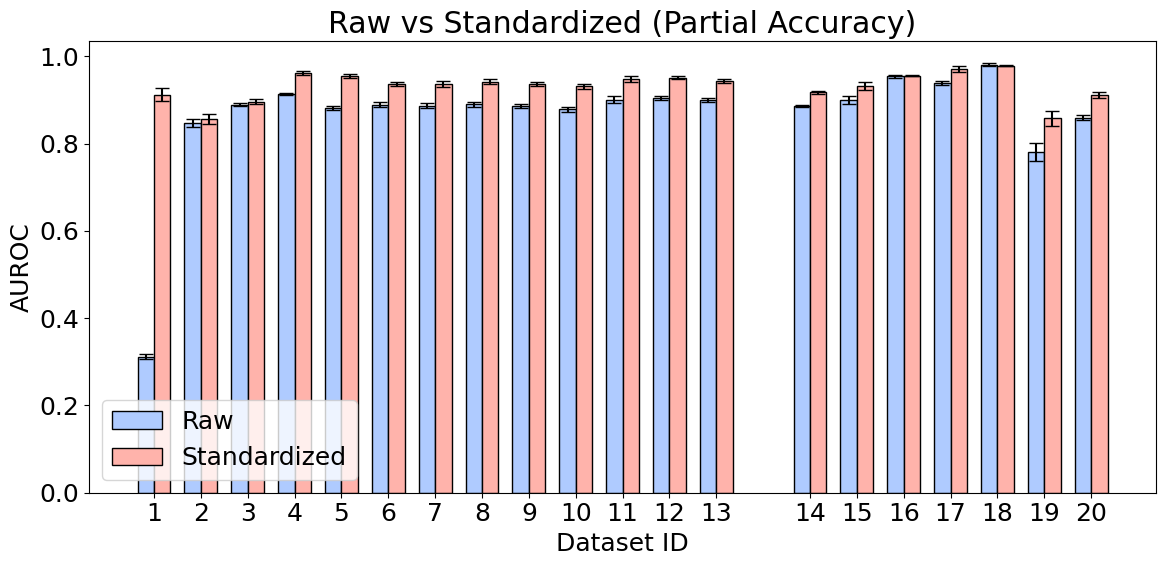

In [62]:
#S1-a
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

eff =[]
ci_l = []
ci_u = []
dif = []
# データの定義
dfa= pd.read_csv("/workspace/2406_paper/output2.csv")
dfb= pd.read_csv("/workspace/2406_paper/output_ADME.csv")

dfs = pd.concat([dfa,dfb])
df1 = dfs[(dfs["Data"] == "n") & (dfs["hue"] == "no")]

df2 = dfs[(dfs["Data"] == "n") & (dfs["hue"] == "n")]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


ADME_Tox = ["2_PAMPA_NCATS","3_HIA_Hou","4_Pgp_Broccatelli","5_Bioavailability_Ma","9_BBB_Martins","12_CYP2C19_Veith","13_CYP2D6_Veith","14_CYP3A4_Veith","15_CYP1A2_Veith","16_CYP2C9_Veith", "17_CYP2C9_Substrate_CarbonMangels","18_CYP2D6_Substrate_CarbonMangels","19_CYP3A4_Substrate_CarbonMangels","2_hERG","4_hERG_Karim","5_AMES","6_DILI","7_Skin Reaction","8_Carcinogens_Lagunin","11_ClinTox"]

# 平均と標準偏差を格納
raw_means = []
std_means = []
raw_stds = []
std_stds = []

for mol in ADME_Tox:
    raw_scores = df1[df1["kind"] == mol]["A"]
    std_scores = df2[df2["kind"] == mol]["A"]

    raw_means.append(np.mean(raw_scores))
    std_means.append(np.mean(std_scores))
    raw_stds.append(np.std(raw_scores))
    std_stds.append(np.std(std_scores))

# # データ数
n = len(ADME_Tox)

# x の位置を定義（13以降は +1 する）
x = np.arange(1, n + 1)
x_adjusted = np.array([xi if xi <= 13 else xi + 1 for xi in x])

width = 0.35  # 棒の幅

fig, ax = plt.subplots(figsize=(12, 6))

# 棒グラフの描画
bars1 = ax.bar(x_adjusted - width/2, raw_means, width, yerr=raw_stds, label='Raw',
               color='#AFCBFF', edgecolor='black', capsize=5)
bars2 = ax.bar(x_adjusted + width/2, std_means, width, yerr=std_stds, label='Standardized',
               color='#FFB3AB', edgecolor='black', capsize=5)
plt.rcParams["font.size"] = 18
# 軸・ラベル設定
ax.set_ylabel('AUROC')
ax.set_xlabel('Dataset ID')
ax.set_title('Raw vs Standardized (Partial Accuracy)')
ax.set_xticks(x_adjusted)
ax.set_xticklabels(np.arange(1, n + 1))  # 表示ラベルは 1～n のまま

ax.legend()
plt.tight_layout()
plt.show()

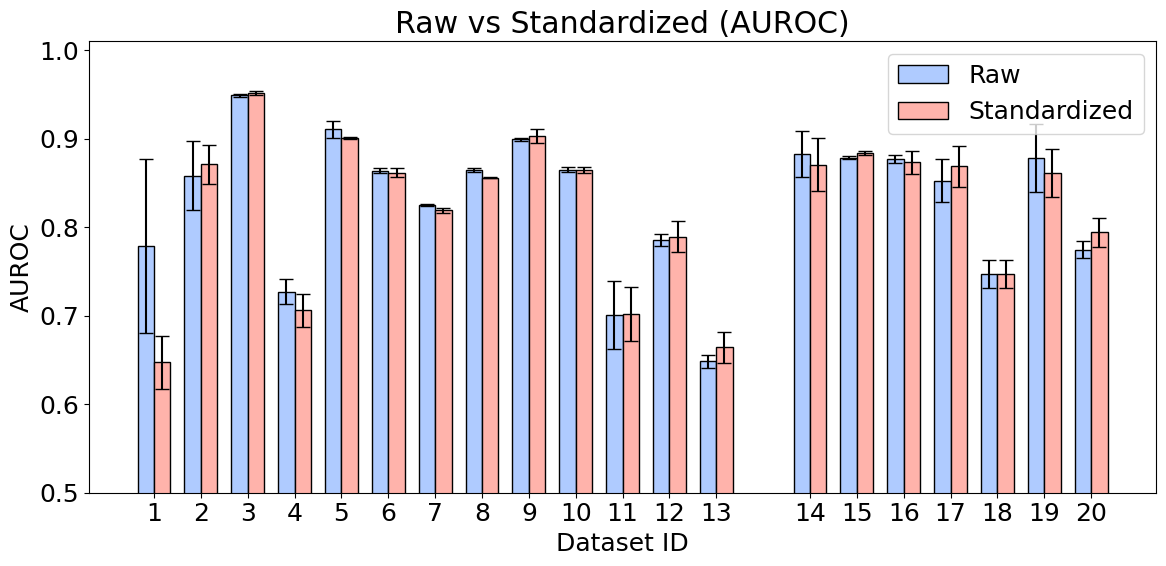

In [64]:
#S1-b
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

eff =[]
ci_l = []
ci_u = []
dif = []

dfa= pd.read_csv("/workspace/2406_paper/n_no.csv")
dfb= pd.read_csv("/workspace/2406_paper/ADME_pre.csv")
dfs = pd.concat([dfa,dfb])
df1 = dfs[(dfs["Data"] == "n") & (dfs["hue"] == "no")]

df2 = dfs[(dfs["Data"] == "n") & (dfs["hue"] == "n")]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


ADME_Tox = ["2_PAMPA_NCATS","3_HIA_Hou","4_Pgp_Broccatelli","5_Bioavailability_Ma","9_BBB_Martins","12_CYP2C19_Veith","13_CYP2D6_Veith","14_CYP3A4_Veith","15_CYP1A2_Veith","16_CYP2C9_Veith", "17_CYP2C9_Substrate_CarbonMangels","18_CYP2D6_Substrate_CarbonMangels","19_CYP3A4_Substrate_CarbonMangels","2_hERG","4_hERG_Karim","5_AMES","6_DILI","7_Skin Reaction","8_Carcinogens_Lagunin","11_ClinTox"]

# 平均と標準偏差を格納
raw_means = []
std_means = []
raw_stds = []
std_stds = []

for mol in ADME_Tox:
    raw_scores = df1[df1["kind"] == mol]["A"]
    std_scores = df2[df2["kind"] == mol]["A"]

    raw_means.append(np.mean(raw_scores))
    std_means.append(np.mean(std_scores))
    raw_stds.append(np.std(raw_scores))
    std_stds.append(np.std(std_scores))

import numpy as np
import matplotlib.pyplot as plt

# データ数
n = len(ADME_Tox)

# x の位置を定義（13以降は +1 する）
x = np.arange(1, n + 1)
x_adjusted = np.array([xi if xi <= 13 else xi + 1 for xi in x])

width = 0.35  # 棒の幅
plt.rcParams["font.size"] = 18
fig, ax = plt.subplots(figsize=(12, 6))

# 棒グラフの描画
bars1 = ax.bar(x_adjusted - width/2, raw_means, width, yerr=raw_stds, label='Raw',
               color='#AFCBFF', edgecolor='black', capsize=5)
bars2 = ax.bar(x_adjusted + width/2, std_means, width, yerr=std_stds, label='Standardized',
               color='#FFB3AB', edgecolor='black', capsize=5)

# 軸・ラベル設定
ax.set_ylabel('AUROC')
ax.set_xlabel('Dataset ID')
ax.set_title('Raw vs Standardized (AUROC)')
ax.set_xticks(x_adjusted)
ax.set_xticklabels(np.arange(1, n + 1))  # 表示ラベルは 1～n のまま
ax.set_ylim(0.5, 1.01)
ax.legend()
plt.tight_layout()
plt.show()


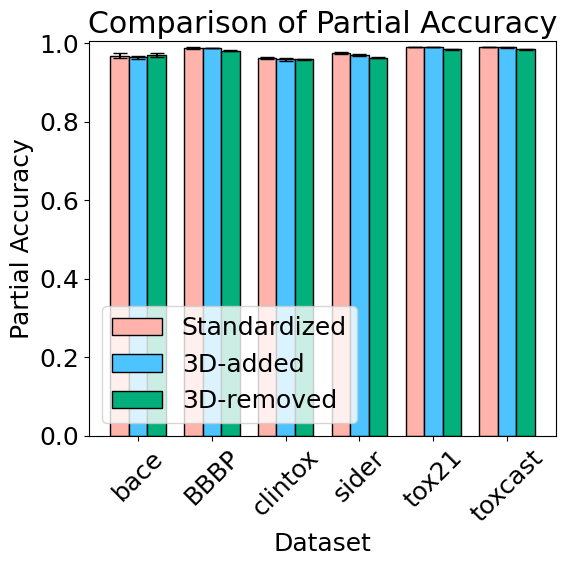

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 共通設定
plt.rcParams["font.size"] = 18
Mol = ["bace", "BBBP", "clintox", "sider", "tox21", "toxcast"]
x = np.arange(len(Mol))  # データセットの数
width = 0.25  # 棒の幅（3本あるので小さめ）

# ---------- 各データ読み込み ----------
dfs_add = pd.read_csv("/workspace/2406_paper/summary_with_params3.csv")
dfs_rem = pd.read_csv("/workspace/2406_paper/summary_with_params2.csv")

# 各条件に該当するデータを抽出
df_std_add = dfs_add[(dfs_add["Param_3"] == "n") & (dfs_add["Param_5"] == "n")]
df_add = dfs_add[(dfs_add["Param_3"] == "p") & (dfs_add["Param_5"] == "p")]

df_std_rem = dfs_rem[(dfs_rem["Param_3"] == "n") & (dfs_rem["Param_5"] == "n")]
df_rem = dfs_rem[(dfs_rem["Param_3"] == "r") & (dfs_rem["Param_5"] == "r")]

# 平均・標準偏差を格納
std_means = []
add_means = []
rem_means = []
std_stds = []
add_stds = []
rem_stds = []

for mol in Mol:
    std_scores_add = df_std_add[df_std_add["Param_6"] == mol]["Partial accuracy"]
    add_scores = df_add[df_add["Param_6"] == mol]["Partial accuracy"]
    std_scores_rem = df_std_rem[df_std_rem["Param_6"] == mol]["Partial accuracy"]
    rem_scores = df_rem[df_rem["Param_6"] == mol]["Partial accuracy"]

    # それぞれ平均・標準偏差
    std_means.append(np.mean(std_scores_add))
    add_means.append(np.mean(add_scores))
    rem_means.append(np.mean(rem_scores))

    std_stds.append(np.std(std_scores_add))
    add_stds.append(np.std(add_scores))
    rem_stds.append(np.std(rem_scores))

# ---------- プロット ----------
fig, ax = plt.subplots(figsize=(6, 6))

# バーの描画（位置をずらして並べる）
ax.bar(x - width, std_means, width, yerr=std_stds, label='Standardized',
       color='#FFB3AB', edgecolor='black', capsize=5)
ax.bar(x, add_means, width, yerr=add_stds, label='3D-added',
       color='#4DC4FF', edgecolor='black', capsize=5)
ax.bar(x + width, rem_means, width, yerr=rem_stds, label='3D-removed',
       color='#03AF7A', edgecolor='black', capsize=5)

# 軸設定
ax.set_ylabel('Partial Accuracy')
ax.set_xlabel('Dataset')
ax.set_title('Comparison of Partial Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(Mol, rotation=45)
ax.set_ylim(0.0, 1.005)
ax.legend()

plt.tight_layout()
plt.show()
